# **Analisis Exploratorio de Datos de los Dataseets Competition IV 2a y 2b**

## **1. Analisis Exploratorio para el Dataseet Competition IV 2a**

### **1.1. Introducción**

Es uno de los conjuntos de datos más utilizados para el desarrollo y validación de algoritmos en interfaces cerebro-computadora (BCI) basadas en imaginación motora (MI). Fue publicado por el laboratorio BBCI (Berlin Brain-Computer Interface) en la Graz University of Technology y contiene señales de electroencefalografía (EEG) registradas en un entorno controlado, con el objetivo de evaluar la capacidad de distintos modelos para discriminar entre tareas motoras imaginadas.

Los datos fueron extraidos de 9 sujetos sanos, cada uno equipado con 22 electrodos EEG distribuidos según el sistema 10-20 y 3 electrodos EOG para remoción de artefactos por movimiento ocular. Los datos fueron muestreados a 250 Hz y filtradas con un pasa bandas entre 0.5 Hz y 100 Hz y un filtro notch en 50 Hz, el estudio se llevo a cabo en 2 sesiones en dias diferentes por sujeto que imaginaba 4 diferentes clases de movimientos (Movimiento de mano derecha, de mano izquierda, de lengua y de pies), dando un lugar a 288 entrenamientos por grabación (72 entrenamientos para cada tipo de imaginación motora). 

Cada sesión inicio con 5 minutos de evalución del EOG que serán omitidos para este estudio. Para el estudio de los epochs se tomo en cuenta que según la información provista por el dataseet cada trial esta compuesto como se muestra en la imagen por:
- Fixation cross: [0; 2] seg
- Cue: [2; 3.25] seg
- Motor Imagery: [3; 6] seg
- Break: [6; 7.5] seg  

<p align="center">

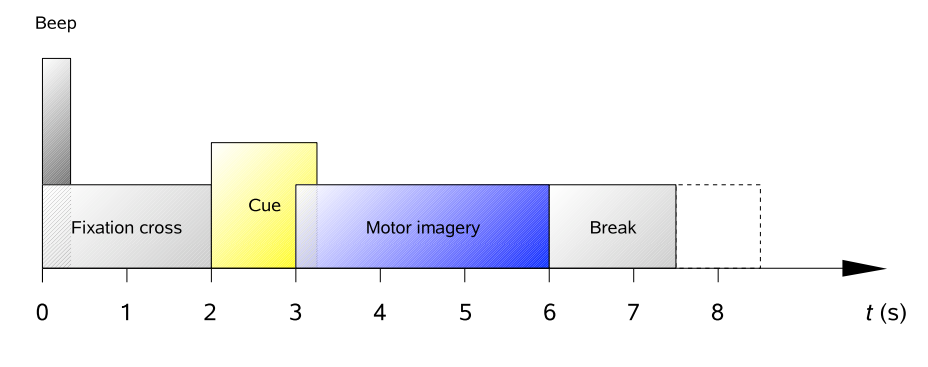

</p>

El dataseet viene en formato GDF y en 2 tipos para cada sujeto (Uno para entrenamiento del clasificador y otro para evaluación), usaremos el de entrenamiento pues posee los nombres de clases para los trials. La siguiente tabla provista en el estudio detalla los numeros en decimal y hexadecimal relacionados a los eventos que marcan momentos específicos en la señal EEG.


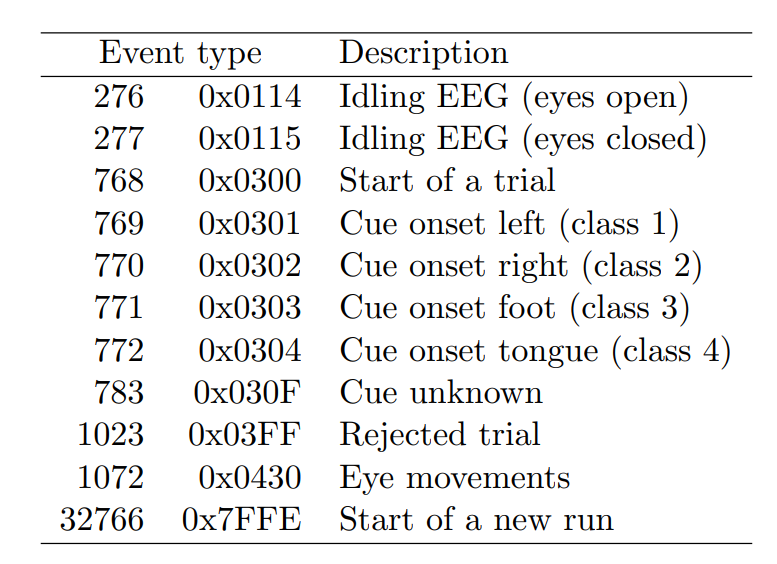

Dentro de los cuales destacamos unicamente los de maxima relevancia para nuestro estudio:
- 768  ->  Inicio de un entrenamiento (son 288 en total para todo el archivo)
- 769  ->  Momento en el que se da la imaginación motora de la mano izquierda
- 770  ->  Momento en el que se da la imaginación motora de la mano derecha



### **1.2. Carga y descripcion de datos**

Iniciamos cargando las librerias a utilizar y el primer archivo correspondiente a la sesión de entrenamiento del primer sujeto. Los principales datos a destacar son:
- Nombre de archivo: A01T.GDF
- 9 Sujetos (A01T - A09T y A01E - A09E) con un total de 18 archivos
- 22 canales EEG + 3 canales EOG
- Frecuencia de muestreo: 250 Hz
- 4 clases (Imaginacion motora de mano derecha, de mano izquierda, de lengua y de pies)
- 288 entrenamientos (72 por clase)
- Filtrado con pasabandas de 0.5 a 100 Hz
- Numero de muestras en el tiempo: 672528
- Nombre de los canales principales: 'EEG-Fz', 'EEG-C3', 'EEG-Cz', 'EEG-C4', 'EEG-Pz' 

In [392]:
import numpy as np
import mne # Libreria principal para análisis de señales EEG en formato GDF
import matplotlib.pyplot as plt
from mne.filter import filter_data
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Cargamos el archivo GDF del sujeto 1 de entrenamiento del dataseet 2a con mne
ruta = r'F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2a_gdf\A01T.gdf'
raw = mne.io.read_raw_gdf(ruta, preload = True) 
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right']) # Eliminamos los canales de EOG, quedandonos con los 22 canales EEG

Extracting EDF parameters from F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\dell\anaconda3\envs\BCI-env\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

### **1.3. Visualización de datos y filtrado temporal**

Primeramente generamos la visualización de los datos EEG de todos los canales en crudo, es decir, sin el filtrado. De donde visualizamos de mejor forma los siguientes datos:
- La duración de toda la señal es de aproximadamente 2700 segundos (45 minutos)
- La amplitud de la señal esta en el orden de uV (Aproximadamente 15 uV post filtrado temporal)

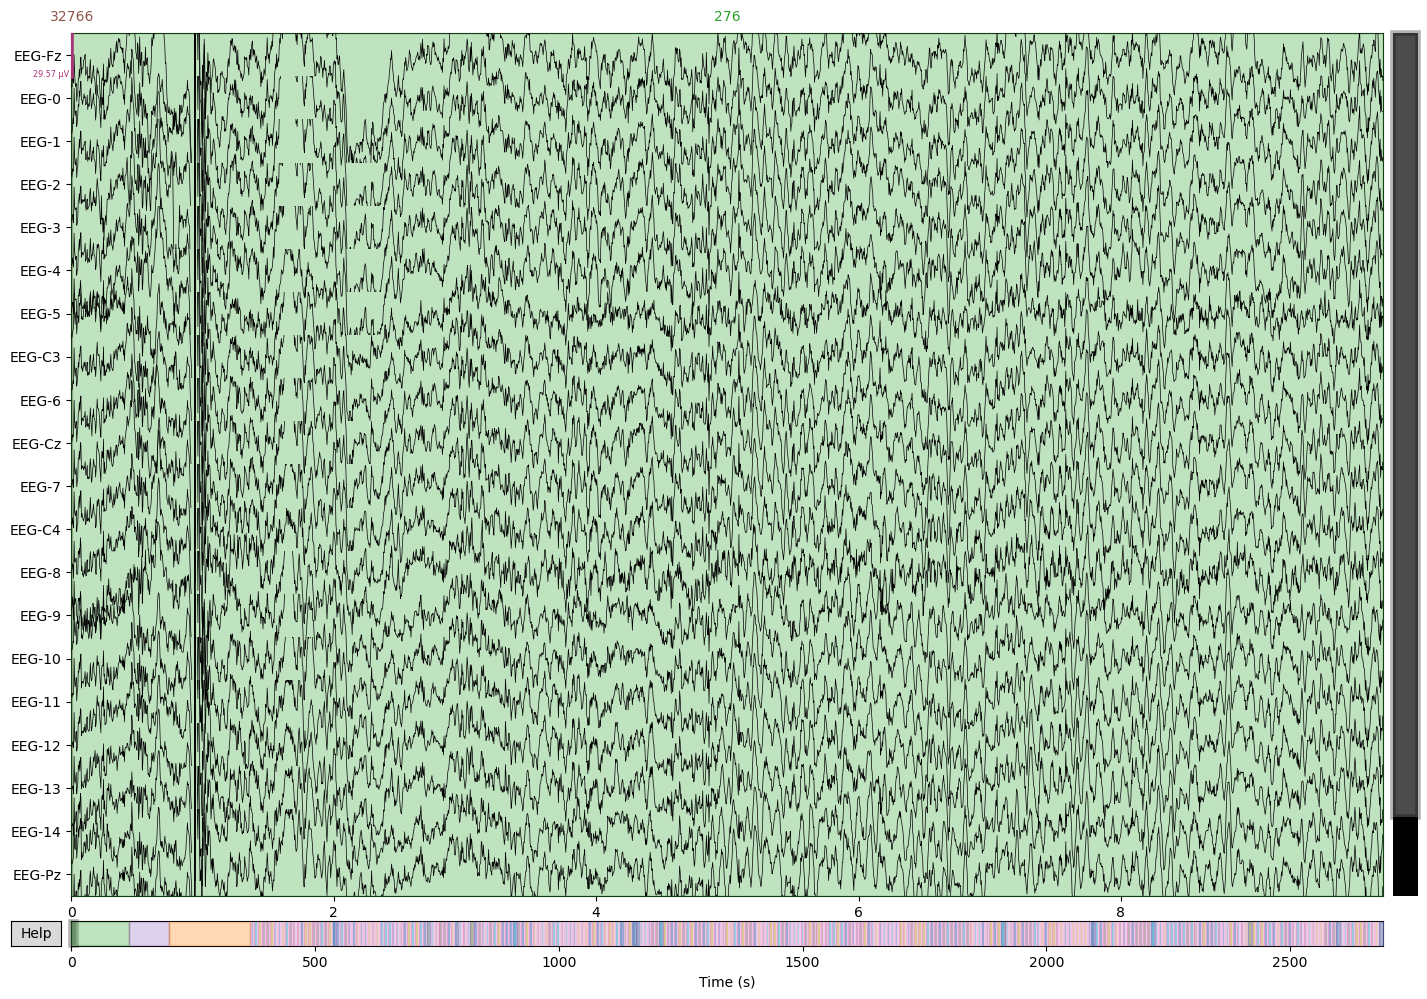

In [393]:
# Grafica de las señales EEG
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

Ahora realizamos el filtrado temporal correspondiente para obtener la señal en la banda alfa y beta y suprimir las frecuencias fuera de este rango

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



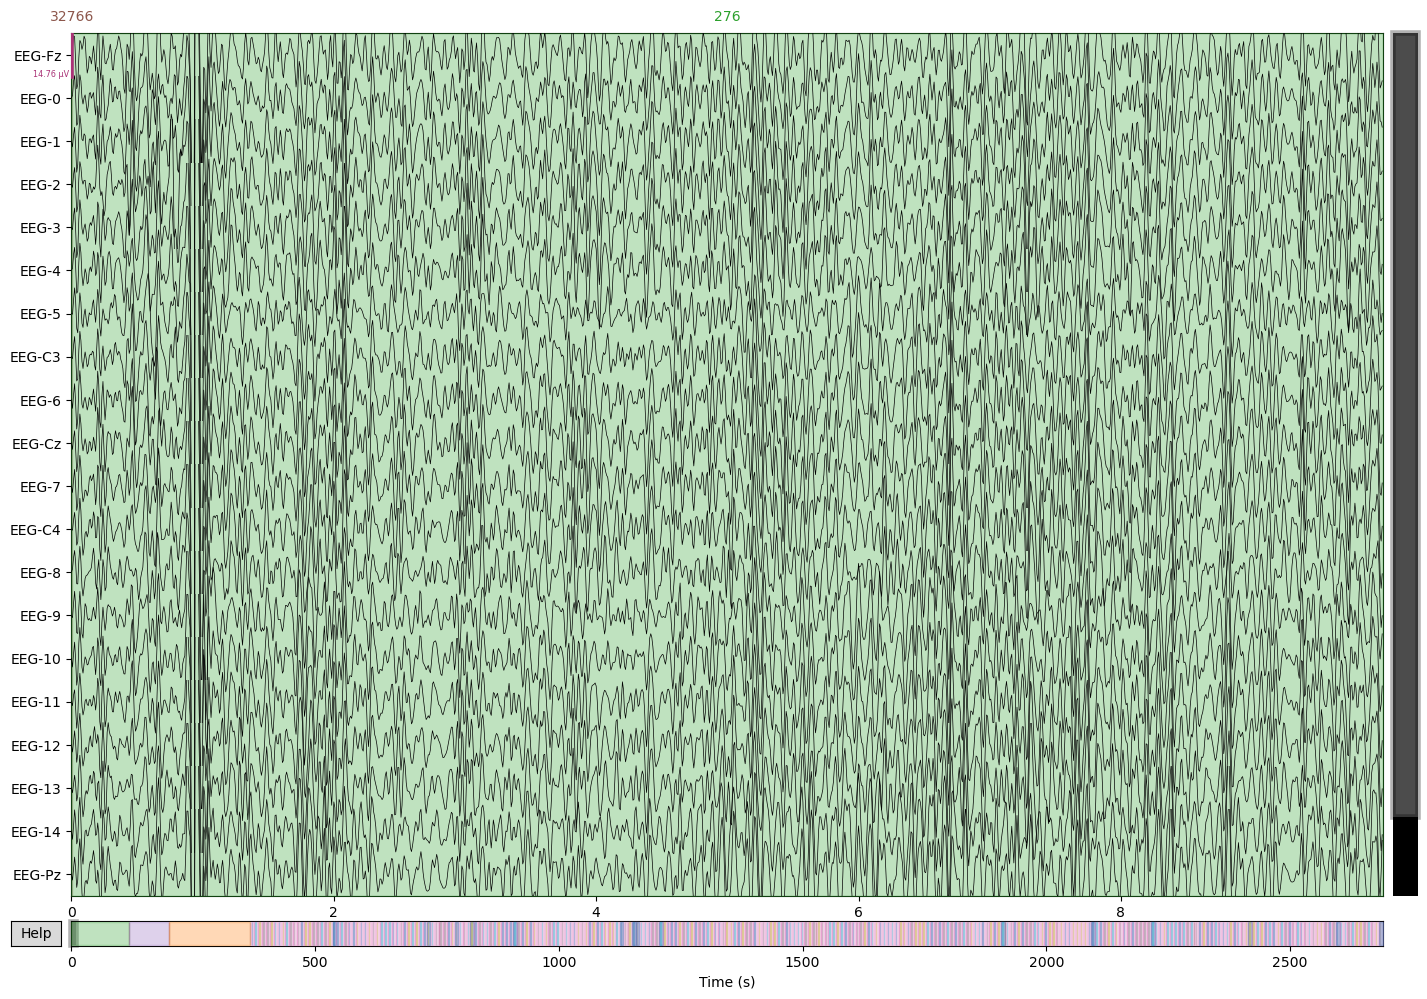

In [394]:
raw_filtered = raw.copy().filter(l_freq=8., h_freq=30., fir_design='firwin')
fig = raw_filtered.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()


Ahora realizaremos una pequeña comparación para verificar un filtrado adecuado entre los electrodos de mayor relevancia (C3 y C4) para imaginación motora pre y post filtrado.

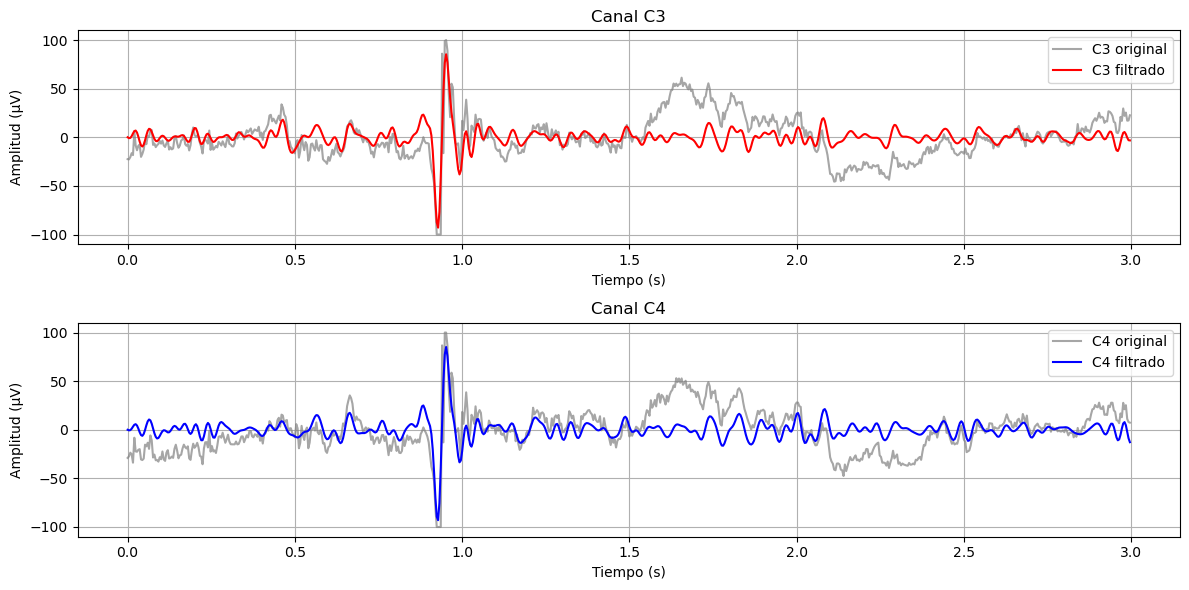

In [395]:
fs = int(raw.info['sfreq']) # Frecuencia de muestreo (250 Hz)
t_inicio = 0                      
t_duracion = 3                  
t_muestras = slice(t_inicio*fs, (t_inicio+t_duracion)*fs) # Rango de muestras a mostrar
data_raw, times = raw.get_data(picks=['EEG-C3', 'EEG-C4'], return_times=True)
data_filt, _ = raw_filtered.get_data(picks=['EEG-C3', 'EEG-C4'], return_times=True)

plt.figure(figsize=(12, 6))
# Comparativa para canal C3
plt.subplot(2, 1, 1)
plt.plot(times[t_muestras], data_raw[0, t_muestras]*1e6, label='C3 original', color='gray', alpha=0.7)
plt.plot(times[t_muestras], data_filt[0, t_muestras]*1e6, label='C3 filtrado', color='red')
plt.title('Canal C3')
plt.ylabel('Amplitud (µV)')
plt.xlabel('Tiempo (s)')
plt.legend()
plt.grid(True)
# Comparativa para canal C4
plt.subplot(2, 1, 2)
plt.plot(times[t_muestras], data_raw[1, t_muestras]*1e6, label='C4 original', color='gray', alpha=0.7)
plt.plot(times[t_muestras], data_filt[1, t_muestras]*1e6, label='C4 filtrado', color='blue')
plt.title('Canal C4')
plt.ylabel('Amplitud (µV)')
plt.xlabel('Tiempo (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **1.4. Estructura de clases y eventos**

Una clase no es nada mas que el tipo de imaginación motora que se da, como hablamos en la introducción del dataseet, existen 4 diferentes tipos de clases. Donde cada una representa uno de los 4 diferentes tipos de imaginación motora que se evalúan. De los cuales en este trabajo nos centramos unicamente en las clases: Imaginación motora de mano derecha (Evento 770, Clase 2) e Imaginación motora de la mano izquierda (Evento 769, Clase 1). 

In [396]:
events = mne.events_from_annotations(raw_filtered) # Extraemos los eventos de las anotaciones del archivo GDF
events # Imprimimos los eventos

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

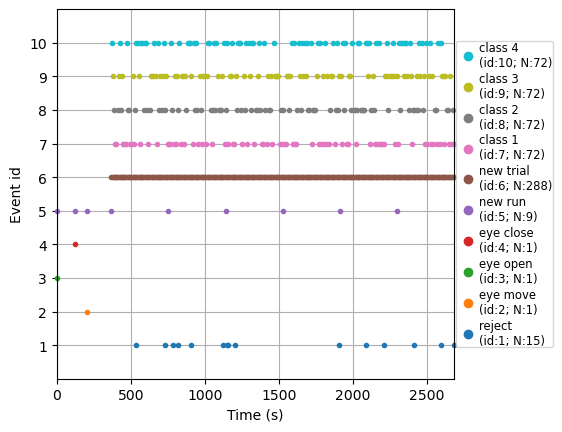

In [397]:
event_dict = {
    'reject': 1, 
    'eye move': 2, # No lo necesitamos
    'eye open': 3, # No lo necesitamos
    'eye close': 4, # No lo necesitamos
    'new run': 5,
    'new trial': 6,
    'class 1': 7, # Movimiento de mano izquierda
    'class 2': 8, # Movimiento de mano derecha
    'class 3': 9, # Movimiento de ambos pies
    'class 4': 10, # Movimiento de lengua
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

### **1.5. Segmentación y epoching**

La información de uitilidad se encuentra en los epochs que son ventanas de tiempo que para este dataseet en particular suceden entre el 2do y el 6to segundo de cada ensayo (trial), pues cada etiqueta de clase inicia desde que se ve la flecha (cue) en la pantalla. Es decir, tenemos un total de 144 epochs que son de nuestro interes (72 para mano derecha y 72 para mano izquierda).

***Epoch:*** Ventanna de tiempo por cada ensayo en el que se da la imaginación motora.

***Evoked:*** Es el promedio de todos los epochs para su respectiva clase de imaginación motora. Es una representación general de como se ve en promedio un epoch. Util para visualización de BCI con p300 pero no de tanta utilidad para Motor Imagery.

In [398]:
epoch = mne.Epochs(raw_filtered, events=events[0], event_id=[7,8], tmin = 0, tmax = 4, baseline=None) # Creamos los epochs de 3 segundos para Motor Imagery de mano izquierda y derecha
epoch.get_data().shape # (n_epochs, n_channels, n_times) = (144, 22, 751)

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1001 original time points ...
0 bad epochs dropped


(144, 22, 1001)

In [399]:
labels = epoch.events[:, -1] -7 # Seleccionamos la ultima columna de la matriz de eventos que tenia 3 columnas
labels # 0 = Movimiento de mano izquierda, 1 = Movimiento de mano derecha

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


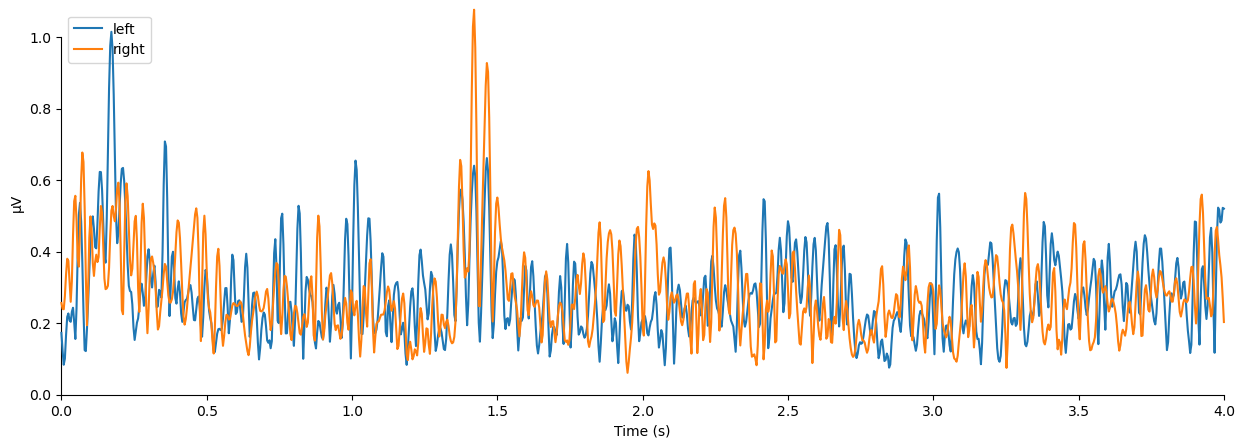

[<Figure size 1500x500 with 1 Axes>]

In [400]:
evoked_left = epoch['7'].average() # Promedio de todos los epochs de MI de mano izquierda
evoked_right = epoch['8'].average() # Promedio de todos los epochs de MI de mano derecha
dicts = {'left': evoked_left, 'right': evoked_right}
fig, ax = plt.subplots(figsize=(15, 5))  # ancho=10, alto=5
mne.viz.plot_compare_evokeds(dicts, axes=ax, show=True)
# Se grafica los evokeds de ambos tipos de imaginación motora

In [401]:
features = epoch.get_data() # Extraemos los datos de los epochs en un array 3D (n_epochs, n_channels, n_times)
# Labels nos muestra el numero de trials 
# Features es un array 3D (n_epochs, n_channels, n_times), donde n_epochs es el numero de trials, n_channels es el numero de canales (22) y n_times es el numero de muestras por trial (202)
labels.shape, features.shape 

Using data from preloaded Raw for 144 events and 1001 original time points ...


((144,), (144, 22, 1001))

Using data from preloaded Raw for 72 events and 1001 original time points ...


Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


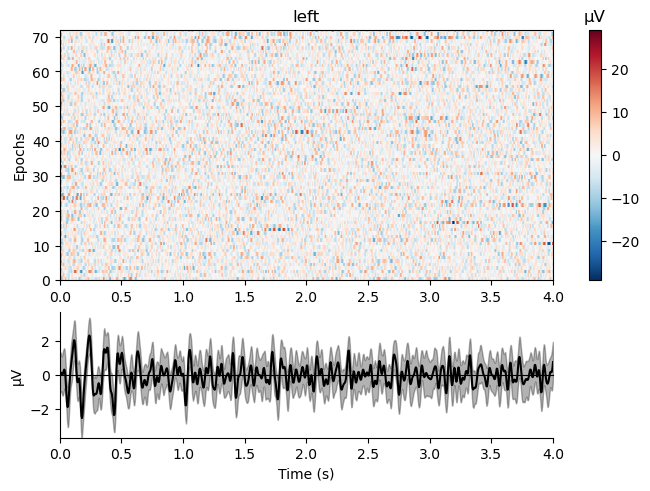

Using data from preloaded Raw for 72 events and 1001 original time points ...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


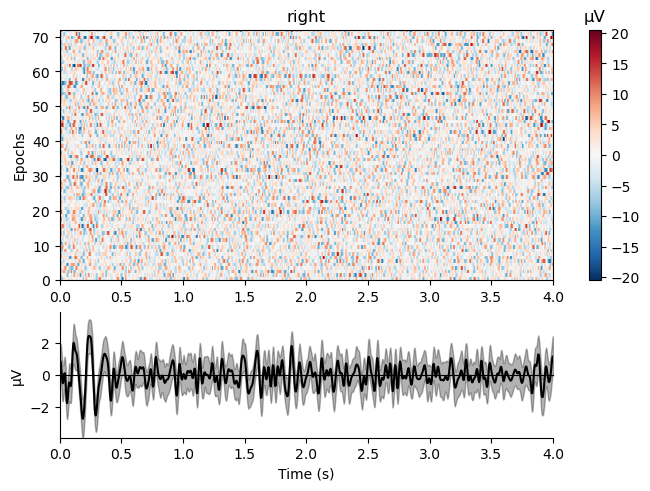

[<Figure size 640x480 with 3 Axes>]

In [402]:
epoch['7'].plot_image(title='left', combine='mean')
epoch['8'].plot_image(title='right', combine='mean')

### **1.6. Analisis espectral de potencia (PSD)**

A diferencia de p300 no podemos distinguir si tenemos la imaginación motora en mano izquierda o derecha viendo el segmento en el tiempo. Nosotros para esto debemos ver cambios en cuanto a la potencia, algo similar a un análisis en frecuencia. Esto reflejado en los 2 tipos de eventos que se dan para imaginación motora:

***ERD (Event-Related Desynchronization):*** Es la disminución de la potencia en las bandas mu y beta (activación cortical). Por ejemplo si una persona imagina movimiento en la mano derecha, se da un ERD en C3 y si la imagina en mano izquierda, se da un ERD en C4. Mientras que si la imagina en los pies se da el ERD mas en Cz.

***ERS (Event-Related Synchronization):*** Es el aumento de la potencia en las bandas mu y beta (inactividad o rebote post tarea). Para calcular la potencia de las bandas se usan epochs, que no son mas que intervalos de tiempo escogidos según la actividad motora. 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Using data from preloaded Raw for 144 events and 1001 original time points ...
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


c:\Users\dell\anaconda3\envs\BCI-env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


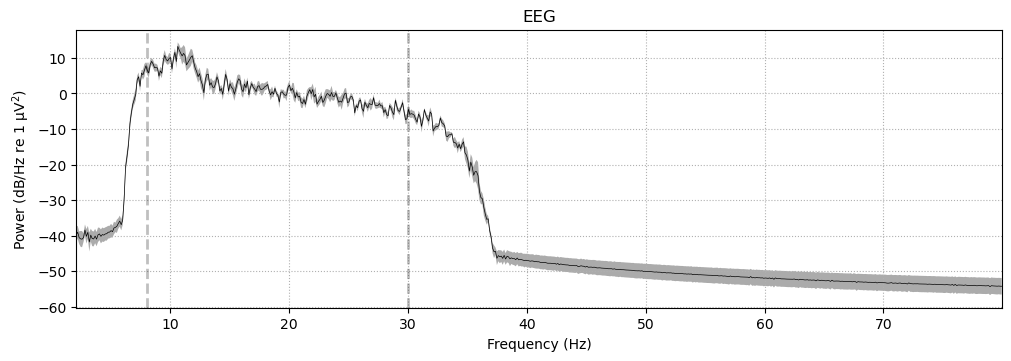

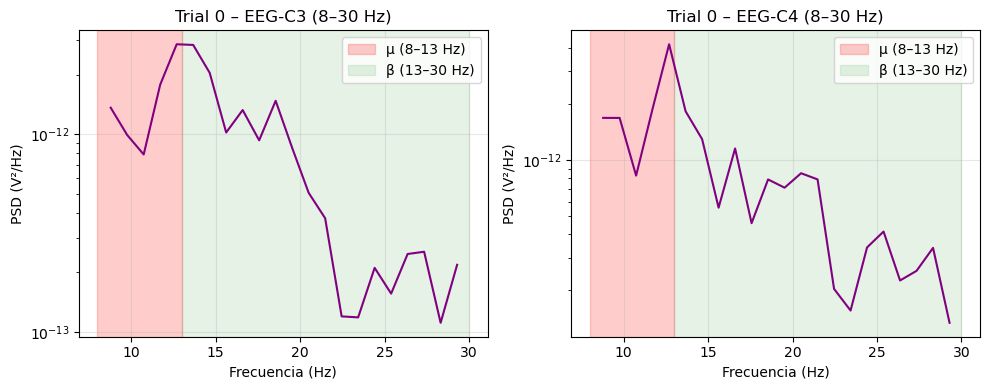

In [403]:
raw_filtered.plot_psd(
    tmin=0, tmax=60, # rango de tiempo a visualizar
    fmin=2, fmax=80, # rango de frecuencias
    average=True, # promedio de canales
    spatial_colors=False
)
# Grafica del PSD promedio de todos los canales, pero nosotros nos enfocaremos en C3 y C4 para decir si hay o no ERD/ERS

trial_idx = 0 # índice del trial a analizar
sfreq = 250                       
channels = ['EEG-C3', 'EEG-C4']    
ch_idx = [epoch.ch_names.index(ch) for ch in channels] # índices de canales
trial_data = epoch.get_data()[trial_idx] # datos del trial seleccionado

def compute_psd_band(trial_data, sfreq, ch_idx, fmin=8, fmax=30):
    """
    Calcula la PSD de un trial en el rango 8–30 Hz (ya filtrado)
    """
    psd, freqs = psd_array_welch(
        trial_data[ch_idx], sfreq=sfreq,
        fmin=fmin, fmax=fmax, n_fft=256, average='mean'
    )
    return psd.squeeze(), freqs

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, ch in enumerate(ch_idx):
    psd, freqs = compute_psd_band(trial_data, sfreq, ch)
    axes[i].semilogy(freqs, psd, color='purple')
    axes[i].set_title(f"Trial {trial_idx} – {channels[i]} (8–30 Hz)")
    axes[i].set_xlabel("Frecuencia (Hz)")
    axes[i].set_ylabel("PSD (V²/Hz)")
    axes[i].grid(True, alpha=0.3)
    axes[i].axvspan(8, 13, color='red', alpha=0.2, label='μ (8–13 Hz)')
    axes[i].axvspan(13, 30, color='green', alpha=0.1, label='β (13–30 Hz)')
    axes[i].legend()

plt.tight_layout()
plt.show()

### **1.7. Feature Extraction**

Ahora si bien podemos utilizar el PSD para el análisis, no es algo que nos de un alto accuracy. Esto es debido a que se trata de una técnica muy simple que no toma en cuenta el filtrado espacial. Por lo que es mas común realizar un análisis por patrones espaciales como es lo que hace el algoritmo CSP (Common Spatial Pattern)

***Algoritmo FBCSP (Filter Bank Common Spatial Patterns):*** Aplica un conjunto de filtros pasabandas con frecuencias de corte alternadas (Por ejemplo, aplica de 8 a 12 Hz, de 12 a 16 Hz, de 16 a 20 Hz y sigue asi ...). Es decir, para una sola señal de un electrodo tendras "M" señales filtradas que para nuestro caso será en todo el espectro de las ondas mu y beta. 
Mientras que el algoritmo Common Spatial Pattern, es un filtro de aprendizaje supervisado que filtra espacialmente y comprime la salida a features que representan potencia. Es el puente de unión entre el procesamiento de la señal y el Machine Learning pues necesita de entrada a un Aprendizaje de Maquina para poder filtrar espacialmente asignandole mediante diferentes calculos y problemas de autovalores, un peso especial a cada electrodo dependiendo de la distancia a la que se encuentren, en nuestro caso dándolo un mayor peso a C3 y C4 y entre estos mismos eligiendo uno de mayor peso para discriminar entre movimiento de mano derecha o izquierda para el Motor Imagery.

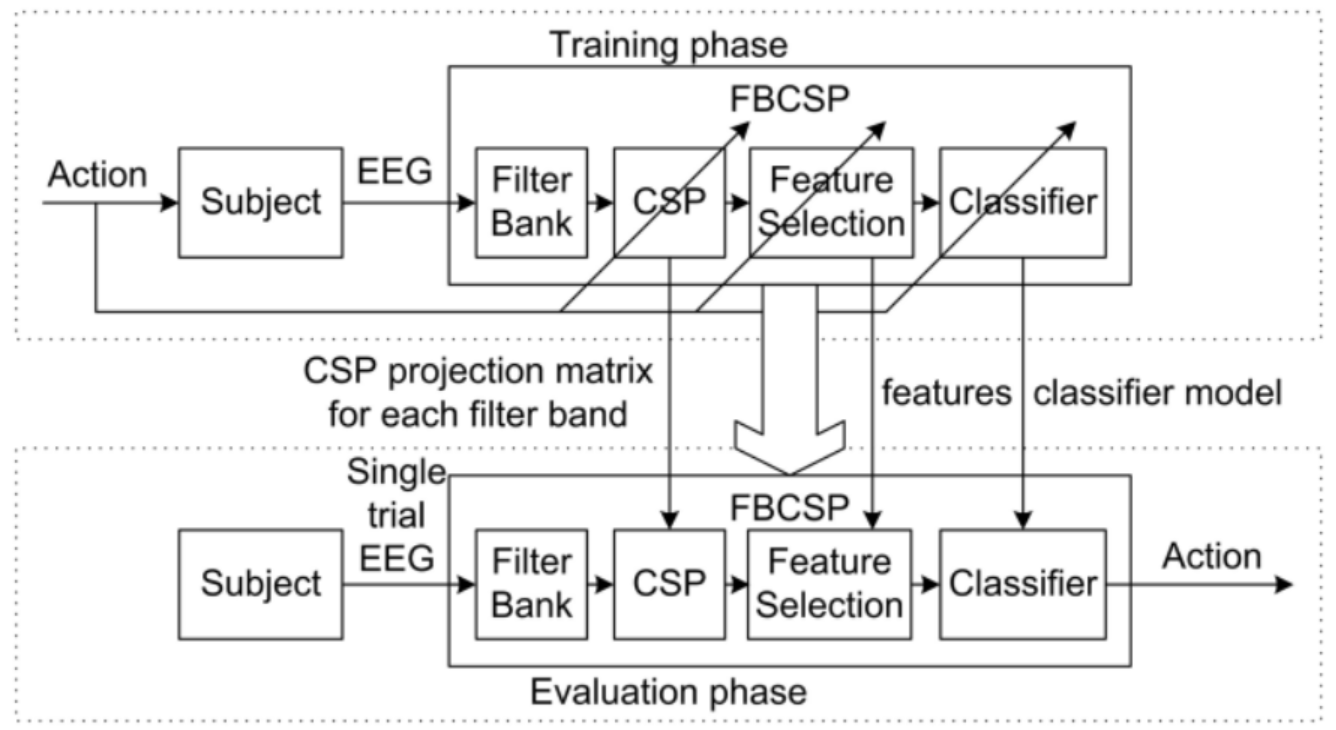

In [404]:
labels = epoch.events[:, -1] -7 # Seleccionamos la ultima columna de la matriz de eventos que tenia 3 columnas
labels # 0 = Movimiento de mano izquierda, 1 = Movimiento de mano derecha

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [405]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()

### **1.8. Conclusiones**